In [23]:
# create a virtual environment and install autokeras, matplotlib, pyarrow
# do not install keras or tensorflow one of them creates dependency issues

# Necessary imports
import autokeras as ak
import matplotlib.pyplot as plt
import numpy as np
import PIL
import os
import pathlib
import pandas as pd
import math

import io
import requests
from PIL import Image

In [4]:
artists = pd.read_parquet('https://kuleuven-datathon-2023.s3.eu-central-1.amazonaws.com/data/Artist.parquet.gzip')
artworks = pd.read_parquet('https://kuleuven-datathon-2023.s3.eu-central-1.amazonaws.com/data/Artwork.parquet.gzip')
specialization = pd.read_parquet('https://kuleuven-datathon-2023.s3.eu-central-1.amazonaws.com/data/Specialization.parquet.gzip')
movement = pd.read_parquet('https://kuleuven-datathon-2023.s3.eu-central-1.amazonaws.com/data/Movement.parquet.gzip')
academy = pd.read_parquet('https://kuleuven-datathon-2023.s3.eu-central-1.amazonaws.com/data/Academy.parquet.gzip')
medium = pd.read_parquet('https://kuleuven-datathon-2023.s3.eu-central-1.amazonaws.com/data/Medium.parquet.gzip')
pictures = pd.read_parquet('https://kuleuven-datathon-2023.s3.eu-central-1.amazonaws.com/data/ArtistPicture.parquet.gzip')
places = pd.read_parquet('https://kuleuven-datathon-2023.s3.eu-central-1.amazonaws.com/data/Places.parquet.gzip')
generated = pd.read_parquet('https://kuleuven-datathon-2023.s3.eu-central-1.amazonaws.com/data/Generated.parquet.gzip')

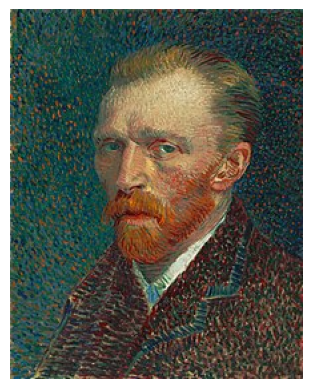

In [5]:
def display_artwork(url):
    response = requests.get(url)
    image = Image.open(io.BytesIO(response.content))
    plt.imshow(image)
    plt.axis("off")
    plt.show()
display_artwork(pictures.url.values[0])

In [24]:
# Collect all data

# Convolutional neural network (CNN) needs same shapes as input, so add zero padding untill max size of all images
new_width = 660
new_height = 660

# Resize images to make it computationally less heavy, might be removed in final regressor
img_size = 250

# Number of images loaded to train regressor, note some images will be removed because they do not have ratings
tot_im = 2000


def get_train_data(label, start_id, end_id):
    x_data = [] 
    y_data = []
    url = label.image_url
    for i in range(start_id,end_id):#label.id:
        try:
            response = requests.get(url[i])
            image = Image.open(io.BytesIO(response.content))
            result = Image.new(image.mode, (new_width, new_height))
            result.paste(image, (0,0))
            result = result.resize((img_size, img_size))
            if ((np.asarray(result).shape == (img_size,img_size,3))
                and (not math.isnan(label.rating[i]))):
                x_data.append(np.asarray(result))
                y_data.append(label.rating[i])
        except Exception as e:
            print(e)
    return (x_data, y_data)

(x_train,y_train) =get_train_data(artworks, 0, tot_im)
tot_val_im = int(0.2*tot_im)
(x_val, y_val) = get_train_data(artworks, tot_im, tot_im+tot_val_im)
(x_test, y_test) = get_train_data(artworks, tot_im+tot_val_im, tot_im+tot_val_im+int(0.1*tot_im))
# fetch 100 images takes 1 minute

HTTPSConnectionPool(host='kuleuven-datathon-2023.s3.eu-central-1.amazonaws.com', port=443): Max retries exceeded with url: /images/Edouard+Manet/Flowers+In+A+Crystal+Vase+I.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001A9B25B1C88>: Failed to establish a new connection: [WinError 10060] Een verbindingspoging is mislukt omdat de verbonden party niet correct heeft geantwoord na een bepaalde tijd, of de gemaakte verbinding is mislukt omdat de verbonden host niet heeft geantwoord'))
HTTPSConnectionPool(host='kuleuven-datathon-2023.s3.eu-central-1.amazonaws.com', port=443): Max retries exceeded with url: /images/Canaletto/La+Piazza+della+Signoria+a+Firenze.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001A9AF90E708>: Failed to establish a new connection: [WinError 10060] Een verbindingspoging is mislukt omdat de verbonden party niet correct heeft geantwoord na een bepaalde tijd, of de gemaakte verbinding is mi

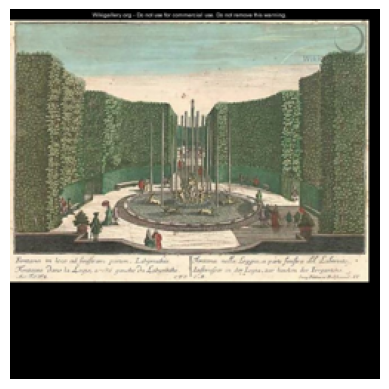

In [25]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
plt.imshow(x_test[1])
plt.axis("off")
plt.show()

In [26]:
## With autokeras does not yet work so ignore
### Initialize the image regressor.
reg = ak.ImageRegressor(overwrite=True, max_trials=1)
### Feed the image regressor with training data.
reg.fit(x_train, y_train, epochs=20)
### Predict with the best model.
predicted_y = reg.predict(x_test)
print(predicted_y)
### Evaluate the best model with testing data.
print(reg.evaluate(x_test, y_test))

Trial 1 Complete [02h 56m 09s]
val_loss: 6.200718402862549

Best val_loss So Far: 6.200718402862549
Total elapsed time: 02h 56m 09s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/20
30/30 [==============================] - 618s 20s/step - loss: 1454.5270 - mean_squared_error: 1454.5270
Epoch 2/20
30/30 [==============================] - 576s 19s/step - loss: 18.5046 - mean_squared_error: 18.5046
Epoch 3/20
30/30 [==============================] - 614s 20s/step - loss: 9.8303 - mean_squared_error: 9.8303
Epoch 4/20
30/30 [==============================] - 591s 20s/step - loss: 14.8106 - mean_squared_error: 14.8106
Epoch 5/20
30/30 [==============================] - 757s 25s/step - loss: 16.0349 - mean_squared_error: 16.0349
Epoch 6/20
30/30 [==============================] - 793s 26s/step - loss: 13.2491 - mean_squared_error: 13.2491
Epoch 7/20
30/30 [==============================] - 617s 20s/step - loss: 27.2142 - mean_squared_error: 27.2142
Epoch 8/20
30/30 [==============================] - 582s 19s/step - loss: 16.4841 - mean_squared_error: 16.4841
Epoch 9/20
30/30 [==============================] - 620s 21s/step - loss: 15.4754 - mean_squared_error

INFO:tensorflow:Assets written to: .\image_regressor\best_model\assets


INFO:tensorflow:Assets written to: .\image_regressor\best_model\assets


4/4 [==============================] - 15s 3s/step
[[11.317704 ]
 [11.17027  ]
 [11.717453 ]
 [10.773221 ]
 [10.97231  ]
 [ 9.042419 ]
 [12.937242 ]
 [10.960206 ]
 [11.030711 ]
 [13.353089 ]
 [11.131926 ]
 [36.486374 ]
 [54.452915 ]
 [38.692795 ]
 [11.105588 ]
 [11.902945 ]
 [20.329412 ]
 [11.090957 ]
 [11.137999 ]
 [25.052404 ]
 [11.177988 ]
 [11.0562315]
 [10.96181  ]
 [11.129635 ]
 [11.200332 ]
 [11.17078  ]
 [10.881464 ]
 [11.0289755]
 [11.08791  ]
 [11.005615 ]
 [10.986158 ]
 [11.045911 ]
 [10.892127 ]
 [11.083813 ]
 [ 9.859759 ]
 [11.095887 ]
 [11.082517 ]
 [11.2569895]
 [10.917445 ]
 [11.056289 ]
 [10.833142 ]
 [ 5.2773695]
 [11.03523  ]
 [11.436821 ]
 [11.203466 ]
 [10.894445 ]
 [11.193949 ]
 [11.217446 ]
 [10.959052 ]
 [10.755098 ]
 [11.245361 ]
 [10.97241  ]
 [10.994813 ]
 [11.166839 ]
 [11.098891 ]
 [40.44775  ]
 [11.013785 ]
 [11.346658 ]
 [ 6.6634927]
 [11.09338  ]
 [11.126182 ]
 [15.139627 ]
 [10.833788 ]
 [12.165911 ]
 [11.065518 ]
 [11.165853 ]
 [10.831566 ]
 [11.333715

In [27]:
model = reg.export_model()

In [28]:
model.summary()
model.save('model_reg_autokeras_ratings_2000im.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 250, 250, 3)      0         
 t32)                                                            
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 8, 8, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 regression_head_1 (Dense)   (None, 1)                 131073    
                                                             

In [29]:
part_x_test = x_test[:]
y_test_pred = reg.predict(part_x_test)
print(y_test[:],y_test_pred)

4/4 [==============================] - 15s 4s/step
[10. 10.  8. 10.  6.  5.  9. 10.  8.  9.  7.  7. 10.  5.  1.  6.  8.  7.
 10. 10. 10.  7.  9. 10.  9. 10.  5. 10.  8. 10. 10.  7.  8.  9. 10.  9.
 10.  6. 10.  8.  7. 10. 10. 10.  6.  9.  6.  9.  9.  9.  8. 10.  8.  8.
  9. 10. 10. 10.  3.  8. 10. 10. 10.  6.  8. 10.  8.  9.  7. 10.  3. 10.
 10.  6. 10.  1.  9. 10. 10. 10. 10. 10. 10. 10.  9.  9.  8. 10.  6. 10.
 10. 10. 10. 10. 10. 10.  8. 10.  9.  8. 10.  1.  8.  5. 10. 10.] [[11.317704 ]
 [11.17027  ]
 [11.717453 ]
 [10.773221 ]
 [10.97231  ]
 [ 9.042419 ]
 [12.937242 ]
 [10.960206 ]
 [11.030711 ]
 [13.353089 ]
 [11.131926 ]
 [36.486374 ]
 [54.452915 ]
 [38.692795 ]
 [11.105588 ]
 [11.902945 ]
 [20.329412 ]
 [11.090957 ]
 [11.137999 ]
 [25.052404 ]
 [11.177988 ]
 [11.0562315]
 [10.96181  ]
 [11.129635 ]
 [11.200332 ]
 [11.17078  ]
 [10.881464 ]
 [11.0289755]
 [11.08791  ]
 [11.005615 ]
 [10.986158 ]
 [11.045911 ]
 [10.892127 ]
 [11.083813 ]
 [ 9.859759 ]
 [11.095887 ]
 [11.082517 ]
